# (6m)Amplitudes

author: steeve.laquitaine@epfl.ch  
last modified: 22.07.2024  
status: up-to-date  

* Saves temp data for plotting and statistics.

## Setup

In [1]:
# import libs
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

import os
import multiprocessing
import torch
import numpy as np
from matplotlib import pyplot as plt
import spikeinterface as si
import pandas as pd
import seaborn as sns
import matplotlib

# move to PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/"
os.chdir(PROJ_PATH)

from src.nodes.utils import get_config, get_stats_config, standardize_layers
from src.nodes.validation import amplitude as amp

# sampling frequency
SF_NV = 30000        
SF_NS = 40000
SF_NE = 20000
SF_NB = 32000


# Marques-Smith
cfg_nv, _ = get_config("vivo_marques", "c26").values() 
RAW_PATH_nv = cfg_nv["raw"]
PREP_PATH_nv = cfg_nv["preprocessing"]["full"]["output"]["trace_file_path"]

# spontaneous biophysical model
cfg_ns, param_conf_ns = get_config("silico_neuropixels", "npx_spont").values()
PREP_PATH_ns = cfg_ns["preprocessing"]["full"]["output"]["trace_file_path"]

# evoked biophysical model
cfg_ne, _ = get_config("silico_neuropixels", "npx_evoked").values()
PREP_PATH_ne = cfg_ne["preprocessing"]["full"]["output"]["trace_file_path"]

# neuropixels (synthetic, Buccino)
cfg_nb, param_conf_nb = get_config("buccino_2020", "2020").values()
PREP_PATH_nb = cfg_nb["preprocessing"]["full"]["output"]["trace_file_path"]

# pipeline parameters
SAVE_FIG = False
SAVE_TEMP_DATA = False
LOAD_TEMP_DATA = True

# save paths
PLOT_DATA_PATH = get_stats_config()["fig2m_data_peak_amplitudes_npx"]


# axes
FIG_SIZE = (1.5, 1)
COLOR_VIVO = np.array([153, 153, 153]) / 255
COLOR_SILI = np.array([228, 26, 28]) / 255
COLOR_BUCCI = np.array([55, 126, 184]) / 255
COLOR_NE = [1, 0.49, 0]
COLOR_MEDIAN = (1, 0.76, 0)

# experiment colors
cl = dict()
cl["COLOR_NV"] = [0.6, 0.6, 0.6]
cl["COLOR_NS"] = [0.9, 0.14, 0.15]
cl["COLOR_NB"] = [0.22, 0.5, 0.72] # blue
cl["COLOR_NE"] = [1, 0.49, 0] # orange
cl["COLOR_HV"] = "k" # black
cl["COLOR_HS"] = np.array([26, 152, 80]) / 255 # green

plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6  # 5-7 with Nature neuroscience as reference
plt.rcParams["lines.linewidth"] = 0.5
plt.rcParams["axes.linewidth"] = 0.5 #1
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.major.size"] = 3.5 * 1.1
plt.rcParams["xtick.minor.size"] = 2 * 1.1
plt.rcParams["ytick.major.size"] = 3.5 * 1.1
plt.rcParams["ytick.minor.size"] = 2 * 1.1
# legend
savefig_cfg = {"transparent":True, "dpi":300}
legend_cfg = {"frameon": False, "handletextpad": 0.1}
tight_layout_cfg = {"pad": 0.5}
LG_FRAMEON = False              # no legend frame
savefig_cfg = {"transparent":True, "dpi": 300}


2024-12-10 15:47:07,069 - root - utils.py - get_config - INFO - Reading experiment config.
2024-12-10 15:47:07,106 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-12-10 15:47:07,107 - root - utils.py - get_config - INFO - Reading experiment config.
2024-12-10 15:47:07,143 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-12-10 15:47:07,144 - root - utils.py - get_config - INFO - Reading experiment config.
2024-12-10 15:47:07,203 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-12-10 15:47:07,204 - root - utils.py - get_config - INFO - Reading experiment config.
2024-12-10 15:47:07,230 - root - utils.py - get_config - INFO - Reading experiment config. - done


## Specs

In [ ]:
# cpus, gpu and current memory usage
print("available cpus:", multiprocessing.cpu_count())
print("available gpus:", torch.cuda.is_available())
%system free -m

: 

## (.3s)Load datasets

* first 10 minutes of recordings for speed

In [2]:
# 1 - Load silico and vivo traces
# neuropixels
RecNS = si.load_extractor(PREP_PATH_ns)
RecNV = si.load_extractor(PREP_PATH_nv)
RecNB = si.load_extractor(PREP_PATH_nb)
RecNE = si.load_extractor(PREP_PATH_ne)

# 3. get traces
# neuropixels
traces_ns = RecNS.get_traces()
traces_nv = RecNV.get_traces()
traces_nb = RecNB.get_traces()
traces_ne = RecNE.get_traces()

# 4 - get good sites (in cortex)
# neuropixels
lyrs = ["L1", "L2/3", "L4", "L5", "L6"]
# silico
site_ly_ns = RecNS.get_property("layers")
site_ly_ns = standardize_layers(site_ly_ns)
sites_ns = np.where(np.isin(site_ly_ns, lyrs))[0]
# evoked
site_ly_ne = RecNE.get_property("layers")
site_ly_ne = standardize_layers(site_ly_ne)
sites_ne = np.where(np.isin(site_ly_ne, lyrs))[0]
# vivo
site_ly_nv = RecNV.get_property("layers")
site_ly_nv = standardize_layers(site_ly_nv)
sites_nv = np.where(np.isin(site_ly_nv, lyrs))[0]

## (3m)Report amplitudes

Expected values: 

- Marques-Smith: 362
M- arques-Smith (all sites): 362
- Biophy. spont.: 361
- Biophy. spont. (all sites): 361
- Biophy. evoked: 387
- Biophy. evoked (all sites): 387

In [46]:
# DENSER PROBE (HORVATH)

# depth 1
print("Marques-Smith:", np.max(np.absolute(traces_nv[:, sites_nv])))
print("Marques-Smith (all sites):", np.max(np.absolute(traces_nv)))

print("Biophy. spont.:", np.max(np.absolute(traces_ns[:, sites_ns])))
print("Biophy. spont. (all sites):", np.max(np.absolute(traces_ns)))

print("Biophy. evoked:", np.max(np.absolute(traces_ne[:, sites_ne])))
print("Biophy. evoked (all sites):", np.max(np.absolute(traces_ne)))

Marques-Smith: 362
Marques-Smith (all sites): 362
Biophy. spont.: 361
Biophy. spont. (all sites): 361
Biophy. evoked: 387
Biophy. evoked (all sites): 387


Expected values:

- Marques-Smith: 272
- Synth.: 273
- Biophy. spont.: 361
- Biophy. evoked: 387

In [8]:
# Max amplitude fit of the synthetic model (L5) to Marques-Smith layer 5
print(
    "Marques-Smith:",
    np.max(np.absolute(traces_nv[:, RecNV.get_property("layers") == "L5"])),
)
print("Synth.:", np.max(np.absolute(traces_nb)))
print(
    "Biophy. spont.:",
    np.max(np.absolute(traces_ns[:, RecNS.get_property("layers") == "L5"])),
)
print(
    "Biophy. evoked:",
    np.max(np.absolute(traces_ne[:, RecNE.get_property("layers") == "L5"])),
)

Marques-Smith: 272
Synth.: 273
Biophy. spont.: 361
Biophy. evoked: 387


## (12m)Compute

In [47]:
# maximum per site
maxs_nv = np.absolute(traces_nv[:, sites_nv]).max(axis=0)
maxs_ns = np.absolute(traces_ns[:, sites_ns]).max(axis=0)
maxs_ne = np.absolute(traces_ne[:, sites_ne]).max(axis=0)
maxs_nb = np.absolute(traces_nb).max(axis=0)

# MS
df = pd.DataFrame()
df["amplitude"] = maxs_nv
df["layer"] = np.array(site_ly_nv)[sites_nv]
df["experiment"] = "npx (Marques-Smith)"
df = df.sort_values(by=["layer"])

# ns
df2 = pd.DataFrame()
df2["amplitude"] = maxs_ns
df2["layer"] = np.array(site_ly_ns)[sites_ns]
df2["experiment"] = "Biophy. spont."
df2 = df2.sort_values(by=["layer"])

# ne
df3 = pd.DataFrame()
df3["amplitude"] = maxs_ne
df3["layer"] = np.array(site_ly_ne)[sites_ne]
df3["experiment"] = "Biophy. evoked"
df3 = df3.sort_values(by=["layer"])

# nb
df4 = pd.DataFrame()
df4["amplitude"] = maxs_nb
df4["layer"] = "L5"
df4["experiment"] = "Synth. (Buccino)"
df4 = df4.sort_values(by=["layer"])

# stack
plot_data = pd.concat([df, df2, df3, df4])
plot_data = plot_data.sort_values(by=["experiment", "layer"])
display(plot_data)

# unit-test
layers = ["L1", "L2/3", "L4", "L5", "L6"]
assert df["layer"].unique().tolist() == layers, "wrong layers"
assert df2["layer"].unique().tolist() == layers, "wrong layers"
assert df3["layer"].unique().tolist() == layers, "wrong layers"
assert df4["layer"].unique().tolist() == ["L5"], "wrong layers"

,amplitude,layer,experiment
100,12,L1,Biophy. evoked
199,17,L1,Biophy. evoked
198,16,L1,Biophy. evoked
150,14,L1,Biophy. evoked
149,17,L1,Biophy. evoked
...,...,...,...
70,242,L6,npx (Marques-Smith)
71,203,L6,npx (Marques-Smith)
72,257,L6,npx (Marques-Smith)
74,165,L6,npx (Marques-Smith)


## Load/Save temp data

In [2]:
# save plot and statistics data
if SAVE_TEMP_DATA:
    plot_data.to_parquet(PLOT_DATA_PATH)
    print("Saved here:", PLOT_DATA_PATH)
elif LOAD_TEMP_DATA:
    plot_data = pd.read_parquet(PLOT_DATA_PATH)

## Plot

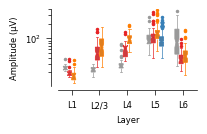

In [57]:
FIG_SIZE = (1.8, 1)

fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE)

ax = sns.boxplot(
    ax=ax,
    data=plot_data,
    x="layer",
    y="amplitude",
    hue="experiment",
    notch=True,
    hue_order=[
        "npx (Marques-Smith)",
        "Biophy. spont.",
        "Biophy. evoked",
        "Synth. (Buccino)",
    ],
    palette=[cl["COLOR_NV"], cl["COLOR_NS"], cl["COLOR_NE"], cl["COLOR_NB"]],
    width=0.6,  # width of the boxplots
    linewidth=0.5,
    flierprops={
        "marker": ".",
        "markersize": 3,
    },
)

ax.set_yscale("log")

# minor ticks
locmin = matplotlib.ticker.LogLocator(
    base=10.0,
    subs=np.arange(0, 1.1, 0.1),
    numticks=10,
)
ax.tick_params(which="both")
ax.yaxis.set_minor_locator(locmin)

# axes
ax.spines[["top", "right"]].set_visible(False)
ax.legend("", frameon=False)

# disconnect axes (R style)
ax.spines["bottom"].set_position(("axes", -0.05))
ax.yaxis.set_ticks_position("left")
ax.spines["left"].set_position(("axes", -0.05))

# ax.legend("", frameon=False)
ax.set_ylabel("Amplitude (\u03bcV)")
ax.set_xlabel("Layer")
ax.set_ylim([0, 400])


# customize the boxplot
p = 0
for box in ax.patches:
    if box.__class__.__name__ == "PathPatch":
        # a list item for each layer group
        if p in [0, 1, 2, 3, 4]:
            box.set_edgecolor(cl["COLOR_NV"])
            # Each box has 6 associated Line2D objects
            # (to make the whiskers, fliers, etc.)
            # Loop over them here, and use the same colour
            # as above
            # group 1 (NV)
            for k in range(6 * p, 6 * (p + 1)):
                ax.lines[k].set_color(cl["COLOR_NV"])  # box
                ax.lines[k].set_mfc(cl["COLOR_NV"])  # whisker
                ax.lines[k].set_mec(cl["COLOR_NV"])  # fliers
            p += 1
        elif p in [5, 6, 7, 8, 9]:
            # group 2 (NS)
            box.set_edgecolor(cl["COLOR_NS"])
            for k in range(6 * p, 6 * (p + 1)):
                ax.lines[k].set_color(cl["COLOR_NS"])
                ax.lines[k].set_mfc(cl["COLOR_NS"])
                ax.lines[k].set_mec(cl["COLOR_NS"])
            p += 1
        elif p in [10, 11, 12, 13, 14]:
            box.set_edgecolor(cl["COLOR_NE"])
            for k in range(6 * p, 6 * (p + 1)):
                ax.lines[k].set_color(cl["COLOR_NE"])
                ax.lines[k].set_mfc(cl["COLOR_NE"])
                ax.lines[k].set_mec(cl["COLOR_NE"])
            p += 1
        elif p in [15]:
            box.set_edgecolor(cl["COLOR_NB"])
            for k in range(6 * p, 6 * (p + 1)):
                ax.lines[k].set_color(cl["COLOR_NB"])
                ax.lines[k].set_mfc(cl["COLOR_NB"])
                ax.lines[k].set_mec(cl["COLOR_NB"])
            p += 1

# save figures
if SAVE_FIG:
    plt.savefig(
        "figures/0_validation/3_amplitude/fig2M/fig2M_npx.svg",
        bbox_inches="tight",
        **savefig_cfg
    )

## Statistics

### Peak amplitude changes across layers?

kruskal-Wallis H statistic corresponds to the $\chi^2$ value

Dunn's test
* Layer 1, 2/3, 4 not different (Dunn's)
* 5 is higher than 4
* 6 is same as 5.

In [4]:
def ci95(data):
    return 1.96 * np.nanstd(data) / np.sqrt(np.sum(~np.isnan(data)))

def get_medians_and_ci95(plot_data, exp, feature: str):
    layers = ["L1", "L2/3", "L4", "L5", "L6"]
    stats = ""
    record = []
    for layer in layers:
        feature_data = plot_data[(plot_data.experiment==exp) & (plot_data.layer==layer)][feature]
        stats += f"{np.round(feature_data.median()*10000)/10000} $\pm$ {np.round(ci95(feature_data),6)}, "
        record.append(np.round(feature_data.median()*10000)/10000)
    print(stats)
    return record
    

# kruskall-wallis
# perform Dunn's posthoc test using a holm-sidak correction for the p-values
# to identify the layer amplitudes that significantly deviate from others
print("\n--------------------MS--------------------\n")
amp.get_kk(plot_data, "npx (Marques-Smith)")
display(amp.get_posthoc_dunn_holm_sidak(plot_data, "npx (Marques-Smith)"))
m_m = get_medians_and_ci95(plot_data, "npx (Marques-Smith)", "amplitude")  


print("\n--------------------NS--------------------\n")
amp.get_kk(plot_data, "Biophy. spont.")
display(amp.get_posthoc_dunn_holm_sidak(plot_data, "Biophy. spont."))
m_ns = get_medians_and_ci95(plot_data, "Biophy. spont.", "amplitude") 


print("\n--------------------E--------------------\n")
amp.get_kk(plot_data, "Biophy. evoked")
amp.get_posthoc_dunn_holm_sidak(plot_data, "Biophy. evoked")
m_e = get_medians_and_ci95(plot_data, "Biophy. evoked", "amplitude")  


--------------------MS--------------------

H=152.8743941927725, p=4.928295200897696e-32
N_L1 = 10 sites
N_L23 = 42 sites
N_L4 = 34 sites
N_L5 = 42 sites
N_L6 = 98 sites


,L1,L2/3,L4,L5,L6
L1,1.000000,7.876522e-01,7.770120e-01,3.974711e-06,3.974711e-06
L2/3,0.787652,1.000000e+00,9.036291e-02,1.900421e-18,4.757496e-23
L4,0.777012,9.036291e-02,1.000000e+00,2.814567e-09,1.226009e-10
L5,0.000004,1.900421e-18,2.814567e-09,1.000000e+00,7.876522e-01
L6,0.000004,4.757496e-23,1.226009e-10,7.876522e-01,1.000000e+00


24.0 $\pm$ 3.000785, 22.5 $\pm$ 0.931331, 26.5 $\pm$ 4.317716, 86.5 $\pm$ 12.822917, 81.5 $\pm$ 14.582104, 

--------------------NS--------------------

H=120.96224182280432, p=3.327550887170644e-25
N_L1 = 16 sites
N_L23 = 47 sites
N_L4 = 19 sites
N_L5 = 52 sites
N_L6 = 68 sites


,L1,L2/3,L4,L5,L6
L1,1.000000e+00,3.980106e-06,0.000002,1.617924e-18,4.799396e-03
L2/3,3.980106e-06,1.000000e+00,0.287096,1.083379e-07,1.187457e-02
L4,2.454186e-06,2.870963e-01,1.000000,5.793268e-03,5.793268e-03
L5,1.617924e-18,1.083379e-07,0.005793,1.000000e+00,1.617924e-18
L6,4.799396e-03,1.187457e-02,0.005793,1.617924e-18,1.000000e+00


18.5 $\pm$ 2.959713, 48.0 $\pm$ 8.623294, 62.0 $\pm$ 12.478448, 105.5 $\pm$ 16.510134, 35.5 $\pm$ 3.531232, 

--------------------E--------------------

H=123.3395376193485, p=1.0332794645624923e-25
N_L1 = 16 sites
N_L23 = 47 sites
N_L4 = 19 sites
N_L5 = 52 sites
N_L6 = 68 sites
16.5 $\pm$ 3.197784, 65.0 $\pm$ 11.491886, 94.0 $\pm$ 16.833962, 126.5 $\pm$ 18.710603, 42.5 $\pm$ 5.969636, 


## Buccino's model

In [26]:
# medians and ci95
get_medians_and_ci95(plot_data, "Synth. (Buccino)", "amplitude")  

nan $\pm$ nan, nan $\pm$ nan, nan $\pm$ nan, 85.5 $\pm$ 3.7, nan $\pm$ nan, 


# Are Models and in vivo data the same?

In [3]:
from scipy.stats import kruskal
import scikit_posthocs as sp


def count_sites(df, exp, layer):
    return len(df[(df["experiment"] == exp) & (df["layer"] == layer)])


def get_amplitude(df, exp, layer):
    return df[(df["experiment"] == exp) & (df["layer"] == layer)]["amplitude"].values


def get_kk_compare_exps(df, layer):
    """kruskall wallis test
    """
    h, p = kruskal(
        get_amplitude(df, "npx (Marques-Smith)", layer),
        get_amplitude(df, "Biophy. spont.", layer),
        get_amplitude(df, "Biophy. evoked", layer),
    )
    print(f"H={h}, p={p}")
    print(f"""N_L1 = {count_sites(df, "Biophy. spont.", layer)} sites""")
    print(f"""N_L23 = {count_sites(df, "Biophy. evoked", layer)} sites""")
    print(f"""N_L4 = {count_sites(df, "npx (Marques-Smith)", layer)} sites""")
    
    
def get_posthoc_dunn_holm_sidak_compare_exps(plot_data, layer):
    """posthoc test after kruskall wallis with Dunn and holm_sidak
    multiple comparison correction of p-values

    Args:
        plot_data (_type_): _description_
        exp (_type_): _description_

    Returns:
        _type_: _description_
    """
    data = [
        get_amplitude(plot_data, "npx (Marques-Smith)", layer),
        get_amplitude(plot_data, "Biophy. spont.", layer),
        get_amplitude(plot_data, "Biophy. evoked", layer),
    ]
    # holm sidak method has more power than Bonferroni which is more conservative
    # Non-significance can indicate subtle differences, power issues, samll sample size,
    # or the balancing be due to how the Holm-Sidak correction controls Type I errors
    # while retaining power.
    # we can still look at the p-values to identify trends.
    df = sp.posthoc_dunn(data, p_adjust="holm-sidak")
    df.columns = ["npx (Marques-Smith)", "Biophy. spont.", "Biophy. evoked"]
    df.index = ["npx (Marques-Smith)", "Biophy. spont.", "Biophy. evoked"]
    return df

def get_posthoc_dunn_holm_sidak_compare_exps_l5(plot_data, layer):
    """posthoc test after kruskall wallis with Dunn and holm_sidak
    multiple comparison correction of p-values

    Args:
        plot_data (_type_): _description_
        exp (_type_): _description_

    Returns:
        _type_: _description_
    """
    data = [
        get_amplitude(plot_data, "npx (Marques-Smith)", layer),
        get_amplitude(plot_data, "Biophy. spont.", layer),
        get_amplitude(plot_data, "Biophy. evoked", layer),
        get_amplitude(plot_data, "Synth. (Buccino)", layer),
    ]
    # holm sidak method has more power than Bonferroni which is more conservative
    # Non-significance can indicate subtle differences, power issues, samll sample size,
    # or the balancing be due to how the Holm-Sidak correction controls Type I errors
    # while retaining power.
    # we can still look at the p-values to identify trends.
    df = sp.posthoc_dunn(data, p_adjust="holm-sidak")
    df.columns = ["npx (Marques-Smith)", "Biophy. spont.", "Biophy. evoked", "Synth. (Buccino)"]
    df.index = ["npx (Marques-Smith)", "Biophy. spont.", "Biophy. evoked", "Synth. (Buccino)"]
    return df

In [ ]:
print("------LAYER 1:------\n")

# kruskall-wallis
# perform Dunn's posthoc test using a holm-sidak correction for the p-values
# to identify the amplitudes that significantly deviate from others
get_kk_compare_exps(plot_data, "L1")
display(get_posthoc_dunn_holm_sidak_compare_exps(plot_data, "L1"))


print("\n------LAYER 2/3:------\n")

get_kk_compare_exps(plot_data, "L2/3")
display(get_posthoc_dunn_holm_sidak_compare_exps(plot_data, "L2/3"))

print("\n------LAYER 4:------\n")

get_kk_compare_exps(plot_data, "L4")
display(get_posthoc_dunn_holm_sidak_compare_exps(plot_data, "L4"))

print("\n------LAYER 5:------\n")

get_kk_compare_exps(plot_data, "L5")
display(get_posthoc_dunn_holm_sidak_compare_exps_l5(plot_data, "L5"))

print("\n------LAYER 6:------\n")

get_kk_compare_exps(plot_data, "L6")
display(get_posthoc_dunn_holm_sidak_compare_exps(plot_data, "L6"))

------LAYER 1:------

H=12.515296039199686, p=0.0019157462997591108
N_L1 = 16 sites
N_L23 = 16 sites
N_L4 = 10 sites


,npx (Marques-Smith),Biophy. spont.,Biophy. evoked
npx (Marques-Smith),1.000000,0.052431,0.001212
Biophy. spont.,0.052431,1.000000,0.132458
Biophy. evoked,0.001212,0.132458,1.000000



------LAYER 2/3:------

H=85.91033419958124, p=2.212116317618949e-19
N_L1 = 47 sites
N_L23 = 47 sites
N_L4 = 42 sites


,npx (Marques-Smith),Biophy. spont.,Biophy. evoked
npx (Marques-Smith),1.000000e+00,2.453787e-12,3.823039e-18
Biophy. spont.,2.453787e-12,1.000000e+00,7.914154e-02
Biophy. evoked,3.823039e-18,7.914154e-02,1.000000e+00



------LAYER 4:------

H=47.92536738298209, p=3.9186700820012786e-11
N_L1 = 19 sites
N_L23 = 19 sites
N_L4 = 34 sites


,npx (Marques-Smith),Biophy. spont.,Biophy. evoked
npx (Marques-Smith),1.000000e+00,0.000050,9.601794e-11
Biophy. spont.,4.951118e-05,1.000000,3.263891e-02
Biophy. evoked,9.601794e-11,0.032639,1.000000e+00



------LAYER 5:------

H=20.627688036454504, p=3.3170686187525775e-05
N_L1 = 52 sites
N_L23 = 52 sites
N_L4 = 42 sites


,npx (Marques-Smith),Biophy. spont.,Biophy. evoked,Synth. (Buccino)
npx (Marques-Smith),1.000000,0.152261,1.531374e-04,4.194302e-01
Biophy. spont.,0.152261,1.000000,3.165815e-02,3.206240e-03
Biophy. evoked,0.000153,0.031658,1.000000e+00,9.446307e-11
Synth. (Buccino),0.419430,0.003206,9.446307e-11,1.000000e+00



------LAYER 6:------

H=72.44257662980218, p=1.859064070171466e-16
N_L1 = 68 sites
N_L23 = 68 sites
N_L4 = 98 sites


,npx (Marques-Smith),Biophy. spont.,Biophy. evoked
npx (Marques-Smith),1.000000e+00,5.470375e-15,3.401204e-09
Biophy. spont.,5.470375e-15,1.000000e+00,7.590239e-02
Biophy. evoked,3.401204e-09,7.590239e-02,1.000000e+00


In [17]:
len(plot_data[(plot_data["experiment"] == "npx (Marques-Smith)") & (plot_data["layer"] == "L1")])

10

### H3: Do the spont. model and M-S amplitudes differ? OFTEN.

In [18]:
print("\nlayer 1\n")
amp.get_mwu(plot_data, "npx (Marques-Smith)", "Biophy. spont.", "L1")

print("\nlayer 2/3\n")
amp.get_mwu(plot_data, "npx (Marques-Smith)", "Biophy. spont.", "L2/3")

print("\nlayer 4\n")
amp.get_mwu(plot_data, "npx (Marques-Smith)", "Biophy. spont.", "L4")

print("\nlayer 5\n")
amp.get_mwu(plot_data, "npx (Marques-Smith)", "Biophy. spont.", "L5")
amp.get_mwu(plot_data, "npx (Marques-Smith)", "Synth. (Buccino)", "L5")

print("\nlayer 6\n")
amp.get_mwu(plot_data, "npx (Marques-Smith)", "Biophy. spont.", "L6")


layer 1

1 vs. 2, z=132.5, p=0.0050175695888443235, N_1=10, N_2=16

layer 2/3

1 vs. 2, z=27.5, p=8.126699062006951e-22, N_1=42, N_2=47

layer 4

1 vs. 2, z=51.5, p=2.6828587253456053e-08, N_1=34, N_2=19

layer 5

1 vs. 2, z=865.0, p=0.08498806738109696, N_1=42, N_2=52
1 vs. 2, z=8715.5, p=0.39181311084396553, N_1=42, N_2=384

layer 6

1 vs. 2, z=5693.0, p=1.0651967842503497e-16, N_1=98, N_2=68


### H4: Do evoked model and M-S amplitudes differ? YES?

In [19]:
print("\nlayer 1\n")
amp.get_mwu(plot_data, "npx (Marques-Smith)", "Biophy. evoked", "L1")

print("\nlayer 2/3\n")
amp.get_mwu(plot_data, "npx (Marques-Smith)", "Biophy. evoked", "L2/3")

print("\nlayer 4\n")
amp.get_mwu(plot_data, "npx (Marques-Smith)", "Biophy. evoked", "L4")

print("\nlayer 5\n")
amp.get_mwu(plot_data, "npx (Marques-Smith)", "Biophy. evoked", "L5")

print("\nlayer 6\n")
amp.get_mwu(plot_data, "npx (Marques-Smith)", "Biophy. evoked", "L6")


layer 1

1 vs. 2, z=135.5, p=0.002765951238154765, N_1=10, N_2=16

layer 2/3

1 vs. 2, z=15.0, p=3.0111929352181764e-23, N_1=42, N_2=47

layer 4

1 vs. 2, z=11.0, p=3.2764200161103315e-12, N_1=34, N_2=19

layer 5

1 vs. 2, z=503.5, p=4.042023180805806e-06, N_1=42, N_2=52

layer 6

1 vs. 2, z=5223.0, p=1.1067832770163676e-10, N_1=98, N_2=68


## Summary stats

In [10]:
L1_ns = (24-19)/24 * 100
L1_e = (24-17)/24 * 100

L6_ns = (82-36)/82 * 100
L6_e = (82-43)/82 * 100

print("Models median peak amplitude are on average ", np.round(np.mean([L1_ns, L1_e, L6_ns, L6_e]),1), "% lower than Marques-SMith data")


L23_ns = (23-48)/23 * 100
L23_e = (23-65)/23 * 100

L4_ns = (27-62)/27 * 100
L4_e = (27-94)/27 * 100

L5_ns = (87-106)/87 * 100
L5_e = (87-127)/87 * 100
L5_s = (87-89)/87 * 100

print("Models median peak amplitude are on average ", - np.round(np.mean([L23_ns, L23_e, L4_ns, L4_e, L5_ns, L5_e]),1), "% higher than Marques-SMith data")

Models median peak amplitude are on average  38.4 % lower than Marques-SMith data
Models median peak amplitude are on average  122.8 % higher than Marques-SMith data


In [6]:
def pc(x1, x2):
    return (x1-x2)/x1 * 100

In [8]:
# NEUROPIXELS  ------------------

L1_ns = pc(m_m[0], m_ns[0])
L1_e = pc(m_m[0], m_e[0])

L23_ns = pc(m_m[1], m_ns[1])
L23_e = pc(m_m[1], m_e[1])

L4_ns = pc(m_m[2], m_ns[2])
L4_e = pc(m_m[2], m_e[2])

L5_ns = pc(m_m[3], m_ns[3])
L5_e = pc(m_m[3], m_e[3])

L6_ns = pc(m_m[4], m_ns[4])
L6_e = pc(m_m[4], m_e[4])

# NPX average --------

print("Models median noise are on average ", - np.round(np.median([L1_ns, L1_e, L23_ns, L23_e, L4_ns, L4_e, L5_ns, L5_e, L6_ns, L6_e]),1),  "% Marques-Smith data")

# NPX detailed pattern
print("Models median noise are on average ", - np.round(np.median([L1_ns, L1_e, L6_ns, L6_e]),1), "% Marques-Smith data across L1, L6")

print("Models median noise are on average ", - np.round(np.median([L23_ns, L23_ns, L4_ns, L4_e, L5_ns, L5_e]),1), "% Marques-Smith data, across L4 and L5")

Models median noise are on average  34.1 % Marques-Smith data
Models median noise are on average  -39.6 % Marques-Smith data across L1, L6
Models median noise are on average  113.3 % Marques-Smith data, across L4 and L5
